# Grad-CAM++: Generalized Gradient-based Visual Explanations

TensorFlow 2.X implementation of [Grad-CAM++](https://arxiv.org/pdf/1710.11063.pdf), which produces a heatmap of which regions of an image contributed strongly towards the final prediction.

The photo used for testing was licensed [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/). This stock photo was photographed by [manhhai](https://www.flickr.com/photos/13476480@N07/).

In [1]:
from keras.models import load_model
from keras import Model
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import keras

### Libs versions

In [2]:
print('TensorFlow:', tf.__version__)
print('Keras:', keras.__version__)
print('Pillow:', PIL.__version__)
print('CV2:', cv2.__version__)
print('NumPy: ', np.__version__)

TensorFlow: 2.6.0
Keras: 2.6.0
Pillow: 8.4.0
CV2: 4.4.0
NumPy:  1.20.3


## Properties

## Prepocessing

In [3]:
MODEL_PATH = '../models/model.h5'
IMAGE_PATH = '../pictures/flickr.jpg'
IMAGE_SIZE = (224, 224)
CONV_LAYER_NAME = 'mixed10'
IDX_CATEGORY = 5

### Load model

In [4]:
model = load_model(MODEL_PATH)

2022-03-12 00:05:38.319564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preview image

In [5]:
img_input = cv2.imread(IMAGE_PATH)
img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
img_prepare = cv2.resize(img_input, IMAGE_SIZE)

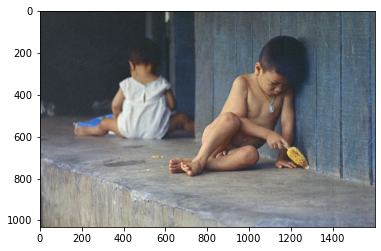

In [6]:
plt.imshow(img_input)

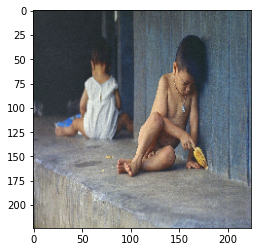

In [7]:
plt.imshow(img_prepare)

### Convert image to array

In [8]:
img_array = np.array(img_prepare) / 255.

## Processing

In [9]:
img_tensor = np.expand_dims(img_array, axis=0)

### Predict

In [10]:
predict = model.predict(img_tensor)
print(np.argmax(predict))
print('Yes' if np.argmax(predict) == IDX_CATEGORY else 'No')

2022-03-12 00:05:45.651010: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


5
Yes


In [11]:
conv_layer = model.get_layer(CONV_LAYER_NAME)
heatmap_model = Model(
    [model.inputs],
    [conv_layer.output, model.output]
)

In [12]:
with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
        with tf.GradientTape() as tape3:
            conv_output, predictions = heatmap_model(img_tensor)
            output = predictions[:, IDX_CATEGORY]
            conv_first_grad = tape3.gradient(output, conv_output)
        conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
    conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

In [13]:
global_sum = np.sum(conv_output, axis=(0, 1, 2))

In [14]:
alpha_num = conv_second_grad[0]
alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum
alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

In [15]:
alphas  = alpha_num / alpha_denom
alpha_normalization_constant = np.sum(alphas, axis=(0, 1))
alphas /= alpha_normalization_constant

In [16]:
weights = np.maximum(conv_first_grad[0], 0.0)

In [17]:
deep_linearization_weights = np.sum(weights * alphas, axis=(0, 1))
grad_cam_map = np.sum(deep_linearization_weights * conv_output[0], axis=2)

In [18]:
heatmap = np.maximum(grad_cam_map, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

## Show heatmap

### Properties

In [19]:
ALPHA = 0.5

### Display

In [20]:
image = cv2.imread(IMAGE_PATH)
image_heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
image_heatmap = (image_heatmap * 255).astype('uint8')
image_heatmap = cv2.applyColorMap(image_heatmap, cv2.COLORMAP_JET)

In [21]:
combine_heatmap = image_heatmap * ALPHA + image
combine_heatmap = np.clip(combine_heatmap, 0, 255).astype('uint8')
combine_heatmap = cv2.cvtColor(combine_heatmap, cv2.COLOR_BGR2RGB)

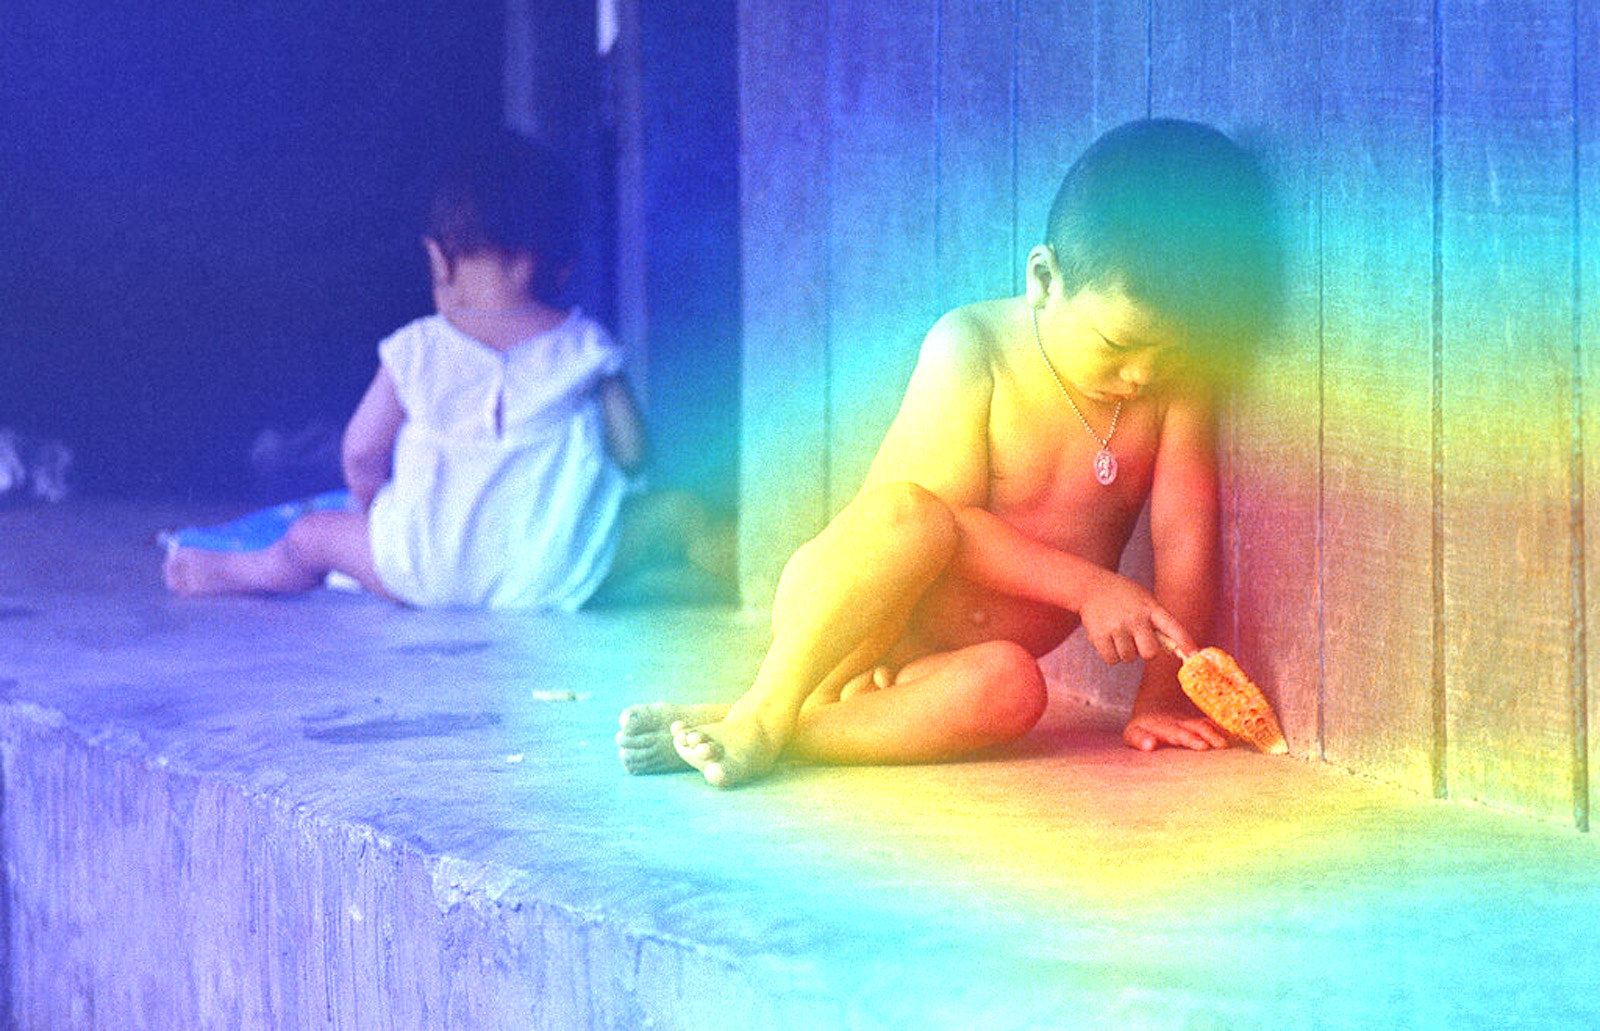

In [22]:
combine_heatmap_img = Image.fromarray(combine_heatmap)
combine_heatmap_img